In [169]:
%load_ext autoreload
%autoreload 2

In [171]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [172]:
from __future__ import division

import numpy as np
import glob, time, pickle, os
import matplotlib.pyplot as plt
import scipy.sparse as sps
import scipy.linalg as sl
from scipy.stats import chi2

import enterprise
from enterprise.pulsar import Pulsar
from enterprise.signals import parameter
from enterprise.signals import white_signals
from enterprise.signals import utils
from enterprise.signals import gp_signals
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise_extensions.frequentist import F_statistic

import Fpstat_enterprise_extensions as My_Fpstat

import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

In [160]:
def get_noise_from_pal2(noisefile):
    psrname = noisefile.split('/')[-1].split('_noise.txt')[0]
    fin = open(noisefile, 'r')
    lines = fin.readlines()
    params = {}
    for line in lines:
        ln = line.split()
        if 'efac' in line:
            par = 'efac'
            flag = ln[0].split('efac-')[-1]
        elif 'equad' in line:
            par = 'log10_equad'
            flag = ln[0].split('equad-')[-1]
        elif 'jitter_q' in line:
            par = 'log10_ecorr'
            flag = ln[0].split('jitter_q-')[-1]
        elif 'RN-Amplitude' in line:
            par = 'red_noise_log10_A'
            flag = ''
        elif 'RN-spectral-index' in line:
            par = 'red_noise_gamma'
            flag = ''
        else:
            break
        if flag:
            name = [psrname, flag, par]
        else:
            name = [psrname, par]
        pname = '_'.join(name)
        params.update({pname: float(ln[1])})
    return params

In [161]:
#Where the enterprise 9yr datafiles are
datadir = enterprise.__path__[0] + '/datafiles/ng9'

parfiles = sorted(glob.glob(datadir + '/*.par'))
timfiles = sorted(glob.glob(datadir + '/*.tim'))
noisefiles = sorted(glob.glob(datadir + '/*noise.txt'))

nine_yr_psrs = [line.rstrip('\n') for line in open(datadir + '/9yr_pulsars.txt','r')]

#Where save directory is:
savedir = os.getcwd()

In [162]:
#Trial with a few pulsars
parfile_J0030 = datadir + '/J0030+0451_NANOGrav_9yv1.gls.par'
parfile_J1640 = datadir + '/J1640+2224_NANOGrav_9yv1.gls.par'

timfile_J0030 = datadir + '/J0030+0451_NANOGrav_9yv1.tim'
timfile_J1640 = datadir + '/J1640+2224_NANOGrav_9yv1.tim'

noisefile_J0030 = datadir + '/J0030+0451_noise.txt'
noisefile_J1640 = datadir + '/J1640+2224_noise.txt'

psr_J0030 = Pulsar(parfile_J0030,timfile_J0030)
psr_J1640 = Pulsar(parfile_J1640,timfile_J1640)

psrs_test = [psr_J0030,psr_J1640]

#Get parameter dict from noisefiles
params_test = {}
params_test.update(get_noise_from_pal2(noisefile_J0030))
params_test.update(get_noise_from_pal2(noisefile_J1640))

In [163]:
#Load all the 9yr pulsars if no pickle file
psr_obj_filename = '/nine_yr_psr_objects.pickle'
psr_obj_file = savedir + psr_obj_filename

try:
    #Load 9yr pulsars from pickle file
    with open(psr_obj_file,'rb') as psrfile:
        psrs_9yr = pickle.load(psrfile)
        psrfile.close()
except:
    #If no pickle file, load and save pulsars
    psrs_9yr = []
    for p, t, nf in zip(parfiles,timfiles,noisefiles):
        psr = Pulsar(p, t)
        for psr_9yr in nine_yr_psrs:
            if psr.name == psr_9yr:
                psrs_9yr.append(psr)
    #Save 9yr pulsars to a pickle file
    with open(psr_obj_file,'wb') as psrfile:
        pickle.dump(psrs_9yr,psrfile)
        psrfile.close()

In [101]:
#Get parameter dict from noisefiles
params_9yr = {}
for nfile in noisefiles:
    noise = get_noise_from_pal2(nfile)
    for key in noise.keys():
        for psr_9yr in nine_yr_psrs:
            if key.startswith(psr_9yr):
                params_9yr.update(noise)

In [102]:
print(params_test)

{'J0030+0451_430_ASP_efac': 1.13871, 'J0030+0451_L-wide_PUPPI_efac': 1.14101, 'J0030+0451_430_PUPPI_efac': 0.917359, 'J0030+0451_L-wide_ASP_efac': 1.12336, 'J0030+0451_430_ASP_log10_ecorr': -7.6001, 'J0030+0451_430_PUPPI_log10_ecorr': -7.11084, 'J0030+0451_L-wide_ASP_log10_ecorr': -7.59912, 'J0030+0451_L-wide_PUPPI_log10_ecorr': -7.64239, 'J0030+0451_430_ASP_log10_equad': -8.27762, 'J0030+0451_L-wide_PUPPI_log10_equad': -6.67303, 'J0030+0451_430_PUPPI_log10_equad': -5.94568, 'J0030+0451_L-wide_ASP_log10_equad': -8.17663, 'J0030+0451_red_noise_log10_A': -14.412, 'J0030+0451_red_noise_gamma': 5.05806, 'J1640+2224_430_ASP_efac': 1.18797, 'J1640+2224_L-wide_PUPPI_efac': 1.25304, 'J1640+2224_430_PUPPI_efac': 1.13544, 'J1640+2224_L-wide_ASP_efac': 1.07335, 'J1640+2224_430_ASP_log10_ecorr': -7.75415, 'J1640+2224_430_PUPPI_log10_ecorr': -7.0865, 'J1640+2224_L-wide_ASP_log10_ecorr': -6.38835, 'J1640+2224_L-wide_PUPPI_log10_ecorr': -7.67906, 'J1640+2224_430_ASP_log10_equad': -6.26644, 'J1640+222

In [103]:
def GetTspan(psrs):
    tmin = [p.toas.min() for p in psrs]
    tmax = [p.toas.max() for p in psrs]
    Tspan = np.max(tmax) - np.min(tmin)
    return Tspan

In [104]:
##### parameters and priors #####
selection = Selection(selections.by_backend)

Tspan_9yr = GetTspan(psrs_9yr)
Tspan_test = GetTspan(psrs_test)

# white noise parameters
efac = parameter.Constant()
log10_equad = parameter.Constant()
ecorr = parameter.Constant()

# red noise parameters
log10_A = parameter.Constant()
gamma = parameter.Constant()

'''
# GW parameters (initialize with names here to use parameters in common across pulsars)
log10_A_gw = parameter.LinearExp(-18,-12)('log10_A_gw')
gamma_gw = parameter.Constant(4.33)('gamma_gw')
'''

# red noise (powerlaw with 30 frequencies)
pl = utils.powerlaw(log10_A=log10_A, gamma=gamma)

rn_9yr = gp_signals.FourierBasisGP(spectrum=pl, Tspan=Tspan_9yr)
rn_test = gp_signals.FourierBasisGP(spectrum=pl, Tspan=Tspan_test)

'''
# gwb (no spatial correlations)
cpl = utils.powerlaw(log10_A=log10_A_gw, gamma=gamma_gw)
gw = gp_signals.FourierBasisGP(spectrum=cpl, components=30, Tspan=Tspan)
'''

# timing model
tm = gp_signals.TimingModel()

##### Set up signals #####

# white noise
ef = white_signals.MeasurementNoise(efac=efac, selection=selection)
eq = white_signals.EquadNoise(log10_equad=log10_equad, selection=selection)
ec = white_signals.EcorrKernelNoise(log10_ecorr=ecorr, selection=selection)

# full model is sum of components
model_9yr = tm + ef + eq + ec + rn_9yr
model_test = tm + ef + eq + ec + rn_test

# intialize PTA
pta_test = signal_base.PTA([model_test(psr) for psr in psrs_test])
pta_9yr = signal_base.PTA([model_9yr(psr) for psr in psrs_9yr])

In [105]:
#Set Default PTA parameters to the ones in the noisefiles
pta_test.set_default_params(params_test)
pta_9yr.set_default_params(params_9yr)

INFO: enterprise.signals.signal_base: Setting J0030+0451_430_ASP_efac to 1.13871
INFO: enterprise.signals.signal_base: Setting J0030+0451_430_PUPPI_efac to 0.917359
INFO: enterprise.signals.signal_base: Setting J0030+0451_L-wide_ASP_efac to 1.12336
INFO: enterprise.signals.signal_base: Setting J0030+0451_L-wide_PUPPI_efac to 1.14101
INFO: enterprise.signals.signal_base: Setting J0030+0451_430_ASP_log10_equad to -8.27762
INFO: enterprise.signals.signal_base: Setting J0030+0451_430_PUPPI_log10_equad to -5.94568
INFO: enterprise.signals.signal_base: Setting J0030+0451_L-wide_ASP_log10_equad to -8.17663
INFO: enterprise.signals.signal_base: Setting J0030+0451_L-wide_PUPPI_log10_equad to -6.67303
INFO: enterprise.signals.signal_base: Setting J0030+0451_430_ASP_log10_ecorr to -7.6001
INFO: enterprise.signals.signal_base: Setting J0030+0451_430_PUPPI_log10_ecorr to -7.11084
INFO: enterprise.signals.signal_base: Setting J0030+0451_L-wide_ASP_log10_ecorr to -7.59912
INFO: enterprise.signals.sig

INFO: enterprise.signals.signal_base: Setting J1024-0719_Rcvr1_2_GASP_log10_ecorr to -7.08522
INFO: enterprise.signals.signal_base: Setting J1024-0719_Rcvr1_2_GUPPI_log10_ecorr to -7.00321
INFO: enterprise.signals.signal_base: Setting J1024-0719_Rcvr_800_GASP_log10_ecorr to -6.96383
INFO: enterprise.signals.signal_base: Setting J1024-0719_Rcvr_800_GUPPI_log10_ecorr to -7.29206
INFO: enterprise.signals.signal_base: Setting J1024-0719_red_noise_log10_A to -16.2659
INFO: enterprise.signals.signal_base: Setting J1024-0719_red_noise_gamma to 3.338
INFO: enterprise.signals.signal_base: Setting J1455-3330_Rcvr1_2_GASP_efac to 1.12806
INFO: enterprise.signals.signal_base: Setting J1455-3330_Rcvr1_2_GUPPI_efac to 1.32475
INFO: enterprise.signals.signal_base: Setting J1455-3330_Rcvr_800_GASP_efac to 1.49365
INFO: enterprise.signals.signal_base: Setting J1455-3330_Rcvr_800_GUPPI_efac to 1.35131
INFO: enterprise.signals.signal_base: Setting J1455-3330_Rcvr1_2_GASP_log10_equad to -8.04522
INFO: ent

INFO: enterprise.signals.signal_base: Setting J1741+1351_L-wide_PUPPI_efac to 1.05026
INFO: enterprise.signals.signal_base: Setting J1741+1351_430_ASP_log10_equad to -7.81532
INFO: enterprise.signals.signal_base: Setting J1741+1351_430_PUPPI_log10_equad to -7.8145
INFO: enterprise.signals.signal_base: Setting J1741+1351_L-wide_ASP_log10_equad to -8.31889
INFO: enterprise.signals.signal_base: Setting J1741+1351_L-wide_PUPPI_log10_equad to -8.06543
INFO: enterprise.signals.signal_base: Setting J1741+1351_430_ASP_log10_ecorr to -5.26368
INFO: enterprise.signals.signal_base: Setting J1741+1351_430_PUPPI_log10_ecorr to -7.35363
INFO: enterprise.signals.signal_base: Setting J1741+1351_L-wide_ASP_log10_ecorr to -7.15877
INFO: enterprise.signals.signal_base: Setting J1741+1351_L-wide_PUPPI_log10_ecorr to -7.31138
INFO: enterprise.signals.signal_base: Setting J1741+1351_red_noise_log10_A to -16.9121
INFO: enterprise.signals.signal_base: Setting J1741+1351_red_noise_gamma to 3.38453
INFO: enterp

INFO: enterprise.signals.signal_base: Setting J2145-0750_Rcvr_800_GASP_log10_ecorr to -6.24509
INFO: enterprise.signals.signal_base: Setting J2145-0750_Rcvr_800_GUPPI_log10_ecorr to -6.57986
INFO: enterprise.signals.signal_base: Setting J2145-0750_red_noise_log10_A to -15.7129
INFO: enterprise.signals.signal_base: Setting J2145-0750_red_noise_gamma to 2.67557
INFO: enterprise.signals.signal_base: Setting J2317+1439_327_ASP_efac to 1.05869
INFO: enterprise.signals.signal_base: Setting J2317+1439_327_PUPPI_efac to 1.14332
INFO: enterprise.signals.signal_base: Setting J2317+1439_430_ASP_efac to 1.12607
INFO: enterprise.signals.signal_base: Setting J2317+1439_430_PUPPI_efac to 1.04287
INFO: enterprise.signals.signal_base: Setting J2317+1439_L-wide_PUPPI_efac to 0.954996
INFO: enterprise.signals.signal_base: Setting J2317+1439_327_ASP_log10_equad to -6.41929
INFO: enterprise.signals.signal_base: Setting J2317+1439_327_PUPPI_log10_equad to -6.39705
INFO: enterprise.signals.signal_base: Setti

In [17]:
# make sure all pulsar have same reference time
def GetRefTime(psrs):
    tt=[] 
    for p in psrs:
        tt.append(np.min(p.toas))

    # find reference time
    tref = np.min(tt)
    newtoas = []
    # now scale pulsar time
    for p in psrs:
        newtoas.append((p.toas - tref))
    return newtoas

In [131]:
def GenNmat(pta,params):
    '''Makes the Nmatrix used in the fstatistic'''
    TNTs = pta.get_TNT(params)
    phiinvs = pta.get_phiinv(params, logdet=False, method='partition') 
    #Get noise parameters for pta toaerr**2
    Nvecs = pta.get_ndiag(params)
    #Get the basis matrix
    Ts = pta.get_basis(params)
    Nmat = []
    print('Making Nmat')
    l1 = np.shape(TNTs)[0]
    i = 1
    
    for phiinv, TNT, Nvec, T in zip(phiinvs, TNTs, Nvecs, Ts):
        start = time.time()
        Sigma = TNT + (np.diag(phiinv) if phiinv.ndim == 1 else phiinv)
        cf = sl.cho_factor(Sigma)      
        Nshape = np.shape(T)[0]
        TtN = Nvec.solve(other = np.eye(Nshape),left_array = T)
        
        #Put pulsar's autoerrors in a diagonal matrix
        Ndiag = Nvec.solve(other = np.eye(Nshape),left_array = np.eye(Nshape))
    
        expval2 = sl.cho_solve(cf,TtN)
        #TtNt = np.transpose(TtN)
        
        #An Ntoa by Ntoa noise matrix to be used in expand dense matrix calculations earlier
        Nmat.append(Ndiag - np.dot(TtN.T,expval2))
        end = time.time()
        print(repr(i) + ' out of ' + repr(l1) + ' Done. Time: ' + repr(end-start))
        i += 1
    return Nmat

In [132]:
#Making small test Nmatrix
Nmat_test = GenNmat(pta_test,params_test)

Making Nmat
1 out of 2 Done. Time: 5.668942213058472
2 out of 2 Done. Time: 7.4422807693481445


In [19]:
#Making Nmatrix for 9yr pulsars
Nmat_9yr = GenNmat(pta_9yr,params_9yr)

Making Nmat
1 out of 18 Done. Time: 22.20108723640442
2 out of 18 Done. Time: 5.517142295837402
3 out of 18 Done. Time: 75.2900161743164
4 out of 18 Done. Time: 249.66445541381836
5 out of 18 Done. Time: 16.125316381454468
6 out of 18 Done. Time: 30.08806586265564
7 out of 18 Done. Time: 69.20558667182922
8 out of 18 Done. Time: 54.38734269142151
9 out of 18 Done. Time: 7.444877624511719
10 out of 18 Done. Time: 571.7044868469238
11 out of 18 Done. Time: 0.9184496402740479
12 out of 18 Done. Time: 103.13256597518921
13 out of 18 Done. Time: 0.6094095706939697
14 out of 18 Done. Time: 170.5114402770996
15 out of 18 Done. Time: 160.79084491729736
16 out of 18 Done. Time: 61.589308977127075
17 out of 18 Done. Time: 58.44939184188843
18 out of 18 Done. Time: 12.155481815338135


In [133]:
def AndrewFpstat2(psrs,Nmat,aligned_toas,f0):
    '''Takes in the full pta, the pulsars that make up the pta 
    (Should make this a function in ptas to use self instead of pta?),
    and the orbital angular frequency of the gravitational wave (usually the search parameter).
    Returns the Fp statistic
    '''
    
    fpstat = 0.0
        
    for ii,p in enumerate(psrs):
        # define N vectors from Ellis et al, 2012 N_i=(x|A_i) for each pulsar
        N = np.zeros(2)
        # define M matrix M_ij=(A_i|A_j)
        M = np.zeros((2, 2))

        # Define A vector
        A = np.zeros((2, len(aligned_toas[ii])))
        A[0,:] = f0**(-1./3.) * np.sin(2*np.pi*f0*aligned_toas[ii])
        A[1,:] = f0**(-1./3.) * np.cos(2*np.pi*f0*aligned_toas[ii])
    
        # define N vectors from Ellis et al, 2012 N_i=(r|A_i) for each pulsar
        N = np.array([np.dot(A[0,:], np.dot(Nmat[ii],p.residuals)), \
                      np.dot(A[1,:], np.dot(Nmat[ii],p.residuals))]) 
        
        # define M matrix M_ij=(A_i|A_j)
        for jj in range(2):
            for kk in range(2):
                M[jj,kk] = np.dot(A[jj,:], np.dot(Nmat[ii], A[kk,:]))
        
        # take inverse of M
        Minv = sl.pinv(M)
        
        fpstat += 0.5 * np.dot(N, np.dot(Minv, N))
    return fpstat

In [134]:
def AndrewFpstat3(pta,psrs,params, f0):
    """
    Computes the Fp-statistic.
    :param f0: GW frequency
    :returns:
    fstat: value of the Fp-statistic at the given frequency
    """
    TNTs = pta.get_TNT(params)
    phiinvs = pta.get_phiinv(params,logdet=False,method='partition')
    
    #Get basis matrix
    Ts = pta.get_basis(params)
    #Get noise parameters for pta toaerr**2
    Nvecs = pta.get_ndiag(params)
    
    N = np.zeros(2)
    M = np.zeros((2,2))
    fstat = 0

    for psr, TNT, phiinv, T, Nvec in zip(psrs, TNTs, phiinvs, Ts, Nvecs):
        Nmat = F_statistic.make_Nmat(phiinv,TNT,Nvec,T)
        Sigma = TNT + (np.diag(phiinv) if phiinv.ndim == 1 else phiinv)

        ntoa = len(psr.toas)

        A = np.zeros((2, ntoa))
        A[0, :] = 1 / f0 ** (1 / 3) * np.sin(2 * np.pi * f0 * psr.toas)
        A[1, :] = 1 / f0 ** (1 / 3) * np.cos(2 * np.pi * f0 * psr.toas)

        ip1 = F_statistic.innerProduct_rr(A[0, :], psr.residuals, Nmat, T, Sigma)
        ip2 = F_statistic.innerProduct_rr(A[1, :], psr.residuals, Nmat, T, Sigma)
        N = np.array([ip1, ip2])

        # define M matrix M_ij=(A_i|A_j)
        for jj in range(2):
            for kk in range(2):
                M[jj, kk] = F_statistic.innerProduct_rr(A[jj, :], A[kk, :], Nmat, T, Sigma)

        # take inverse of M
        Minv = np.linalg.pinv(M)
        fstat += 0.5 * np.dot(N, np.dot(Minv, N))

    return fstat

In [189]:
def gen_fstat_array(psrs,pta=None,params=None,Nmat=None,fstat_class=None,method=3,scale_delf=0,log=False,endfreq=3.3e-7,nfreqs=int(1e3)):
    #Use delf to shift frequencies by less than a bin to get more samples
    Tspan = GetTspan(psrs)
    delf = scale_delf/Tspan
    startfreq = 1/Tspan + delf

    if log:
        #Does not sample independent frequencies
        freqs = np.logspace(np.log10(startfreq),np.log10(endfreq),nfreqs)
    else:
        freqs = np.arange(startfreq,endfreq,1/Tspan)

    i = 1
    fstat_array = []
    start = time.time()
    for f0 in freqs:
        if method == 2:
            #My first attempt
            newtoas = GetRefTime(psrs)
            fstat_array.append(AndrewFpstat2(psrs,Nmat,newtoas,f0))
        elif method == 3:
            #I think a better attempt
            fstat_array.append(AndrewFpstat3(pta,psrs,params,f0))
        elif method == 4:
            #Sarah's enterprise_extensions implementation
            fstat_array.append(fstat_class.compute_Fp(f0))
        if i % 10 == 0:
            end = time.time()
            print(repr(i) + ' Done. ' + ' Time Elapsed: ' + repr(end-start))
        i += 1
        
    end = time.time()
    print(repr(i) + ' Done. ' + ' Time Elapsed: ' + repr(end-start))
    return fstat_array

In [116]:
fstat_array_test_1 = gen_fstat_array(psrs_test,pta=pta_test,params=params_test)

10 Done.  Time Elapsed: 128.9157407283783
20 Done.  Time Elapsed: 260.67912101745605
30 Done.  Time Elapsed: 391.76498460769653
40 Done.  Time Elapsed: 521.7214937210083
50 Done.  Time Elapsed: 651.1541166305542
60 Done.  Time Elapsed: 780.0445680618286
70 Done.  Time Elapsed: 910.7717514038086
80 Done.  Time Elapsed: 1043.345149755478
90 Done.  Time Elapsed: 1175.2528176307678


In [151]:
method = 2
fstat_array_test_2 = gen_fstat_array(psrs_test,Nmat=Nmat_test,method=method)

10 Done.  Time Elapsed: 0.2677652835845947
20 Done.  Time Elapsed: 0.5380954742431641
30 Done.  Time Elapsed: 0.8099274635314941
40 Done.  Time Elapsed: 1.085690975189209
50 Done.  Time Elapsed: 1.3599402904510498
60 Done.  Time Elapsed: 1.62874174118042
70 Done.  Time Elapsed: 1.8923683166503906
80 Done.  Time Elapsed: 2.160449504852295
90 Done.  Time Elapsed: 2.4230592250823975


In [153]:
scale_delf = 1/2
#Adding more frequencies
fstat_array_test_2 += gen_fstat_array(psrs_test,Nmat=Nmat_test,method=method,scale_delf=scale_delf)

10 Done.  Time Elapsed: 0.2660670280456543
20 Done.  Time Elapsed: 0.5373742580413818
30 Done.  Time Elapsed: 0.8093812465667725
40 Done.  Time Elapsed: 1.0842134952545166
50 Done.  Time Elapsed: 1.3607118129730225
60 Done.  Time Elapsed: 1.6282572746276855
70 Done.  Time Elapsed: 1.8943629264831543
80 Done.  Time Elapsed: 2.1702451705932617
90 Done.  Time Elapsed: 2.456935167312622


In [188]:
method = 4
fstat_test_extensions = My_Fpstat.FpStat(psrs_test,pta_test,params_test)
fstat_array_test_3 = gen_fstat_array(psrs_test,fstat_class=fstat_test_extensions,method=method)

Initializing the model...
10 Done.  Time Elapsed: 13.952607154846191
20 Done.  Time Elapsed: 14.839958429336548
30 Done.  Time Elapsed: 15.702563524246216
40 Done.  Time Elapsed: 16.5515775680542
50 Done.  Time Elapsed: 17.406004667282104
60 Done.  Time Elapsed: 18.26452350616455
70 Done.  Time Elapsed: 19.115209817886353
80 Done.  Time Elapsed: 19.97656273841858
90 Done.  Time Elapsed: 20.882290601730347


In [190]:
scale_delf = 1/2
#Adding more frequencies
fstat_array_test_3 += gen_fstat_array(psrs_test,fstat_class=fstat_test_extensions,method=method,scale_delf=scale_delf)

10 Done.  Time Elapsed: 0.8660352230072021
20 Done.  Time Elapsed: 1.7266404628753662
30 Done.  Time Elapsed: 2.5862157344818115
40 Done.  Time Elapsed: 3.4470696449279785
50 Done.  Time Elapsed: 4.314027309417725
60 Done.  Time Elapsed: 5.178548812866211
70 Done.  Time Elapsed: 6.115057945251465
80 Done.  Time Elapsed: 6.977839469909668
90 Done.  Time Elapsed: 7.822974443435669
93 Done.  Time Elapsed: 8.025284767150879


In [55]:
#Calculate Fstat over frequencies for 9yr dataset
delf = 1/(4*Tspan_9yr)
startfreq_9yr = 1/Tspan_9yr + delf
endfreq_9yr = 3.3e-7 + delf
linfreqs_9yr = np.arange(startfreq_9yr,endfreq_9yr,1/Tspan_9yr)

newtoas_9yr = GetRefTime(psrs_9yr)

j=1
#fstat_array_9yr = []
start = time.time()
for gwfreq in linfreqs_9yr:
    fstat_array_9yr.append(AndrewFpstat2(psrs_9yr,Nmat_9yr,newtoas_9yr,gwfreq))
    if j % 10 == 0:
        end = time.time()
        print(repr(j) + ' Done. ' + ' Time Elapsed: ' + repr(end-start))
    j += 1

10 Done.  Time Elapsed: 23.703097105026245
20 Done.  Time Elapsed: 46.8764750957489
30 Done.  Time Elapsed: 70.00864291191101
40 Done.  Time Elapsed: 93.66167879104614
50 Done.  Time Elapsed: 116.87919306755066
60 Done.  Time Elapsed: 140.53934741020203
70 Done.  Time Elapsed: 163.92767310142517
80 Done.  Time Elapsed: 187.15277886390686
90 Done.  Time Elapsed: 210.8527147769928


# Fp Statistic Histograms and Frequency Plots

In [140]:
def fp_hists(psrs,fstat_array,N_chi=int(1e3),nbins=30):
    #Making chi squared values
    dof = 2*len(psrs)
    chi_x = np.linspace(0,int(max(fstat_array))+1,N_chi)

    plt.hist(2*fstat_array,bins = nbins,density = True)
    plt.plot(chi_x,chi2.pdf(chi_x,dof))
    plt.xlabel(r'$\mathcal{F}_{p}$',fontsize = 'xx-large')
    plt.show()

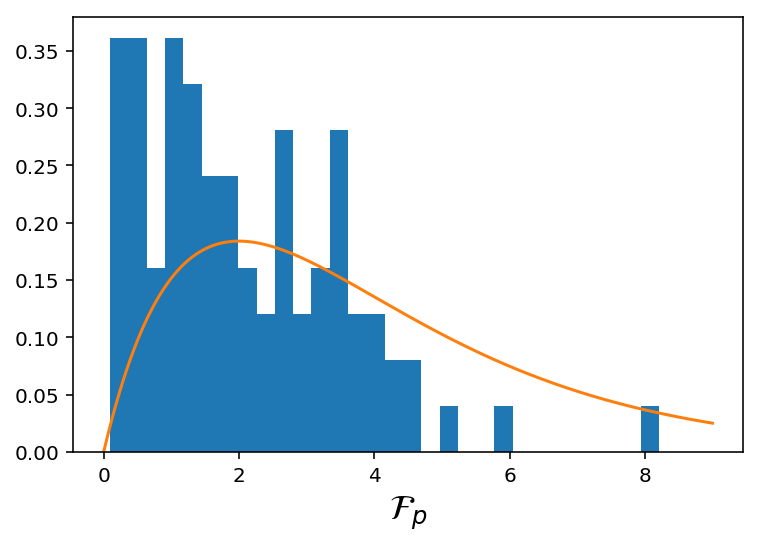

In [141]:
fp_hists(psrs_test,fstat_array_test_1)

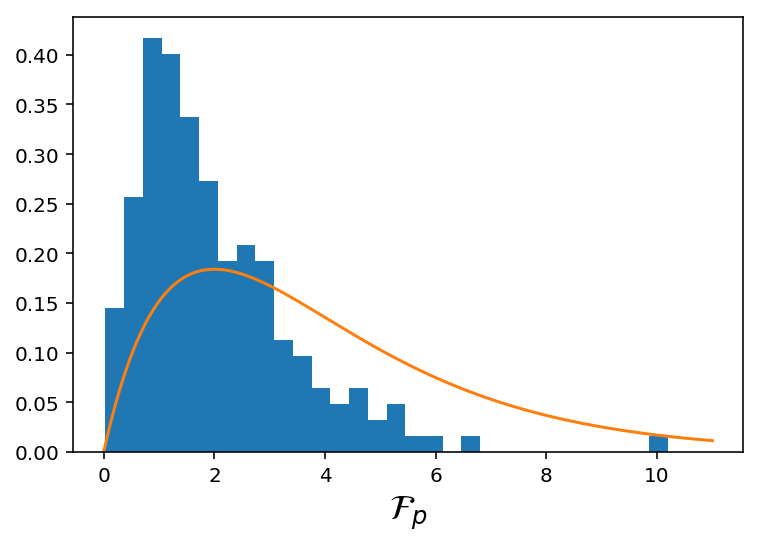

In [191]:
fp_hists(psrs_test,fstat_array_test_3)

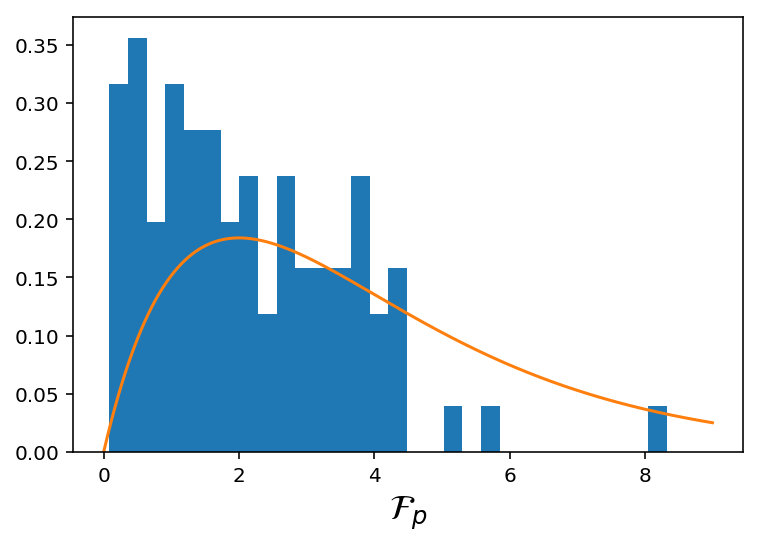

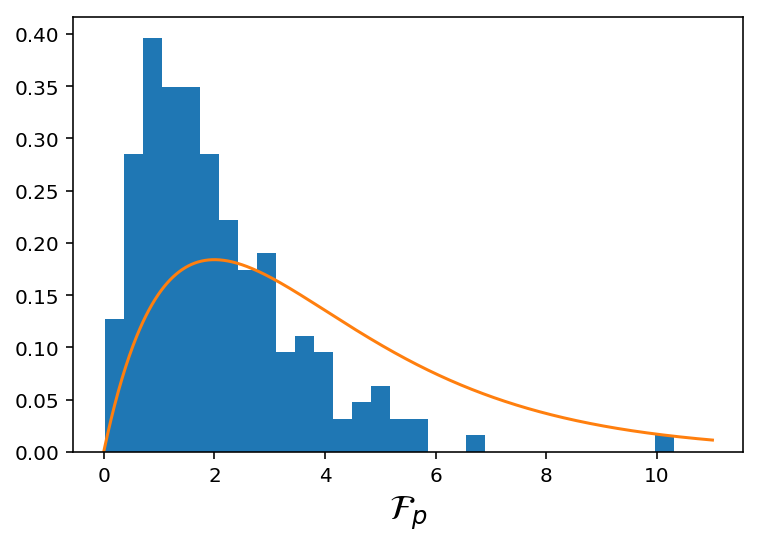

In [155]:
fp_hists(psrs_test,fstat_array_test)
fp_hists(psrs_test,fstat_array_test_2)

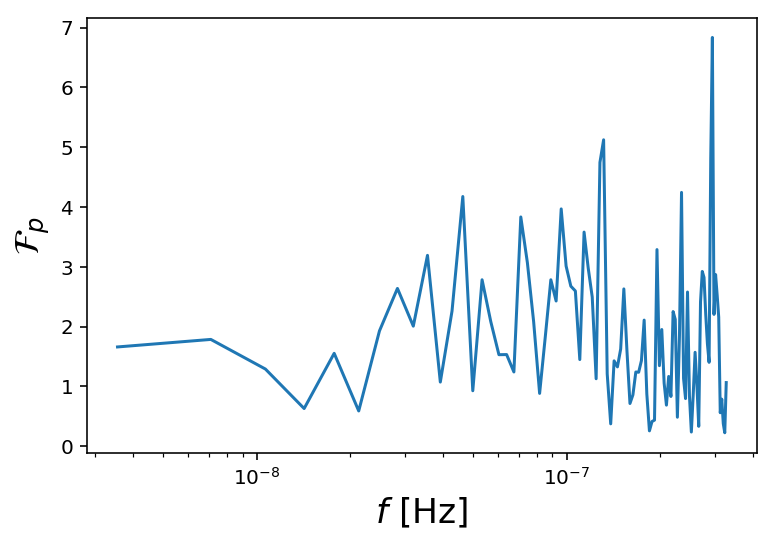

In [57]:
#Test Frequency plots
plt.plot(linfreqs_test,fstat_array_test)
plt.xscale('log')
plt.ylabel(r'$\mathcal{F}_{p}$',fontsize = 'xx-large')
plt.xlabel(r'$f$ [Hz]',fontsize = 'xx-large')
plt.show()

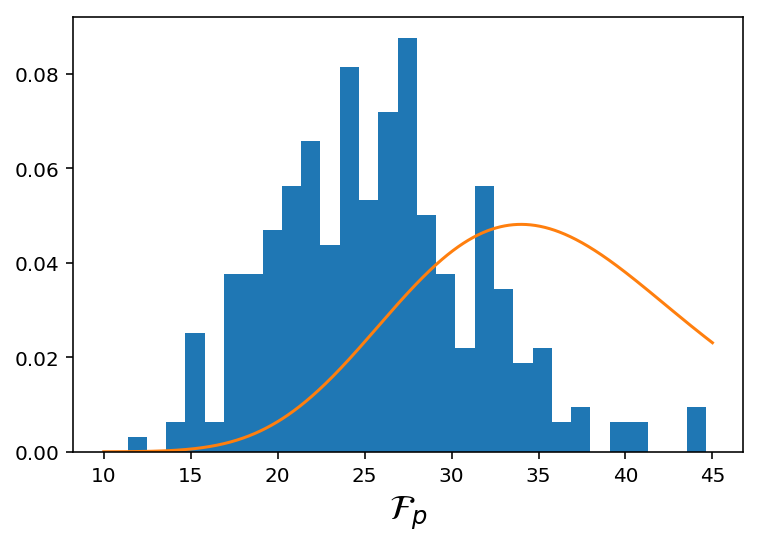

In [58]:
#9yr Histograms
#Making chi squared values
dof_9yr = 2*len(psrs_9yr)
N_x_9yr = 1000
chi_x_9yr = np.linspace(int(min(fstat_array_9yr))-1,int(max(fstat_array_9yr))+1,N_x_9yr)

nbins = 30
plt.hist(2*fstat_array_9yr,bins = nbins,density = True)
plt.plot(chi_x_9yr,chi2.pdf(chi_x_9yr,dof_9yr))
plt.xlabel(r'$\mathcal{F}_{p}$',fontsize = 'xx-large')
plt.show()

# Fe Statistic

In [24]:
def AndrewFestat2(psrs,Nmat,aligned_toas,f0,gwphi,gwtheta):
    '''Takes in the pulsars that make up the pta, the Nmatrix from GetNmat 
    (Should make this a function in ptas to use self instead of pta?),
    the frequency of the gravitational wave, phi (GW azimuthal angle in radians), 
    and theta (GW polar angle in radians).
    Returns the Fe statistic
    '''
    festat = 0.0
    
    #Probably a better way of doing this as well, but using TNTs[ii] for example didn't work
    for ii,p in enumerate(psrs):
        # define N vectors from Ellis et al, 2012 N_i=(x|A_i) for each pulsar
        N = np.zeros(4)
        # define M matrix M_ij=(A_i|A_j)
        M = np.zeros((4,4))

        fplus, fcross, cosMu = utils.create_gw_antenna_pattern(p.pos, gwtheta, gwphi)

        # define A
        A = np.zeros((4, len(aligned_toas[ii])))
        A[0,:] = fplus/f0**(1./3.) * np.sin(2*np.pi*f0*aligned_toas[ii])
        A[1,:] = fplus/f0**(1./3.) * np.cos(2*np.pi*f0*aligned_toas[ii])
        A[2,:] = fcross/f0**(1./3.) * np.sin(2*np.pi*f0*aligned_toas[ii])
        A[3,:] = fcross/f0**(1./3.) * np.cos(2*np.pi*f0*aligned_toas[ii])

        N += np.array([np.dot(A[0,:], np.dot(Nmat[ii],p.residuals)), \
                    np.dot(A[1,:], np.dot(Nmat[ii],p.residuals)), \
                    np.dot(A[2,:], np.dot(Nmat[ii],p.residuals)), \
                    np.dot(A[3,:], np.dot(Nmat[ii],p.residuals))])
    
        # define M matrix M_ij=(A_i|A_j)
        M += np.dot(A, np.dot(Nmat[ii], A.T))
        
        
        # take inverse of M
        Minv = sl.pinv(M)
        
        festat += 0.5 * np.dot(N, np.dot(Minv, N))
        
    return festat

In [25]:
#Pick gw sky location for tests
gwtheta = 30/180*np.pi
gwphi = 10/180*np.pi

64.05763009275555


In [28]:
nfreqs = 1000
Tspan = Tspan_full
freqs = np.logspace(np.log10(1/Tspan),np.log10(3.3e-7),nfreqs)

i = 1
festat_array_full = []
festat_array_test = []
start = time.time()
for gwfreq in freqs:
    festat_array_full.append(AndrewFestat2(psrs_full,Nmat_full,newtoas_full,gwfreq,gwtheta,gwphi))
    #festat_array_test.append(AndrewFestat2(psrs_test,Nmat_test,newtoas_test,gwfreq,gwtheta,gwphi))
    if i % 50 == 0:
        end = time.time()
        print(repr(i) + ' Done. ' + ' Time Elapsed: ' + repr(end-start))
    i += 1

50 Done.  Time Elapsed: 26.16207480430603
100 Done.  Time Elapsed: 37.18350291252136
150 Done.  Time Elapsed: 48.23997259140015
200 Done.  Time Elapsed: 59.172839879989624
250 Done.  Time Elapsed: 70.01483368873596
300 Done.  Time Elapsed: 80.89029455184937
350 Done.  Time Elapsed: 91.98427629470825
400 Done.  Time Elapsed: 102.833913564682
450 Done.  Time Elapsed: 113.77218413352966
500 Done.  Time Elapsed: 124.79858422279358
550 Done.  Time Elapsed: 135.7897868156433
600 Done.  Time Elapsed: 146.98360323905945
650 Done.  Time Elapsed: 158.07582998275757
700 Done.  Time Elapsed: 168.91558456420898
750 Done.  Time Elapsed: 180.00105547904968
800 Done.  Time Elapsed: 191.10464358329773
850 Done.  Time Elapsed: 202.17362093925476
900 Done.  Time Elapsed: 213.30400681495667
950 Done.  Time Elapsed: 224.67976140975952
1000 Done.  Time Elapsed: 236.01119923591614


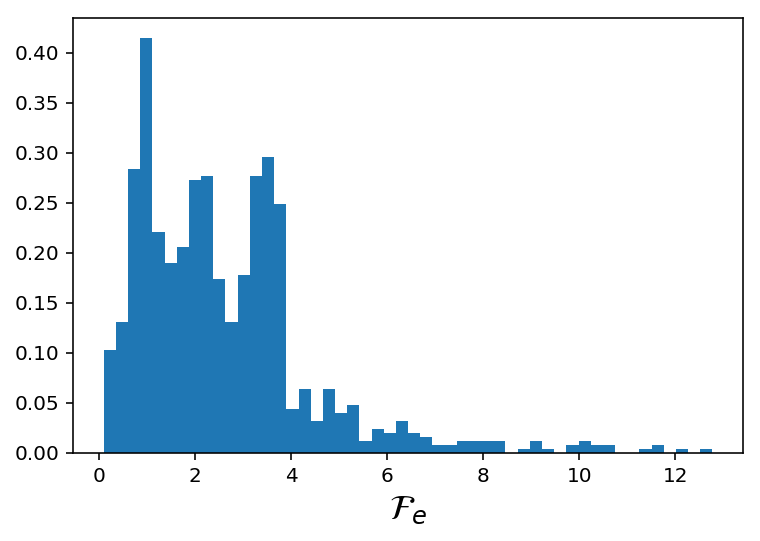

In [60]:
nbins = 50
#plt.hist(fstat_array,bins = nbins,density = True)
plt.hist(festat_array_test,bins = nbins,density = True)
#plt.hist(fstat_array_test,bins = nbins,density = True)
plt.xlabel(r'$\mathcal{F}_{e}$',fontsize = 'xx-large')
plt.show()